In [48]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score,\
    f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [49]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [50]:
X, y = mnist["data"], mnist["target"]

In [51]:
# there are 70,000 images of handwritten digits, with 70000 labels of each
X.shape, y.shape

((70000, 784), (70000,))

In [52]:
# each pixel has value from 0(white) to 255(black)
# and each image is a flat array of size: 28*28=784 pixes
28**2

784

In [53]:
img_number = 33931
X[img_number]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

((-0.5, 27.5, 27.5, -0.5), 5.0)

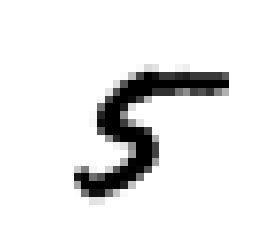

In [54]:
some_digit = X[img_number]
# since array is flat, we need to reshape it to 28x28 size
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="none")
plt.axis("off"), y[img_number]

* shuffle indeces and split into 60k and 10k training and test sets

In [55]:
size = 60000
X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]
idx = np.random.permutation(size)

X_train, y_train = X_train[idx], y_train[idx]

### Binary classifier
* let's just try to identify number 5

In [56]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [57]:
# it's the same shape arrays but with True where there was 5 and False otherwise
y_train_5.shape, y_test_5.shape

((60000,), (10000,))

* let's create a classifier that classifies if an image is 5 or anything else
* a good starting point is Stochastic Gradient Descent (SDG) since it performs well with large datasets

In [58]:
sgd = SGDClassifier(random_state=42, tol=1e-3) # max_iter=5 or tol=1e-3
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [59]:
sgd.predict([some_digit])

array([ True])

### Measuring accuracy using cross-validation

In [60]:
# cv: number of cross-validation folds
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9028, 0.9577, 0.9502])

* let's compare it with a dumb classifier 5, vs not-5

In [61]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [62]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91135, 0.91065, 0.90695])

* we've got 90% accuracy, that's because roughly 1/10th of all images are 5, so 90% of them are non-5

#### !!! when some classes are more frequent than others, accuracy is NOT a good performance measure !!!

In [63]:
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [64]:
# rows - actual class
# cols - predicted class
confusion_matrix(y_train_5, y_train_pred)

array([[51911,  2668],
       [ 1118,  4303]])

In [65]:
#          TN    FP
#          FN    TP

In [66]:
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

### Precision and recall (sensitivity)
* precision (accuracy of positive predictions)
\begin{align}
    precision & = \frac{TP}{TP+FP}
\end{align}
* recall (accuracy of negative predictions)
\begin{align}
    recall & = \frac{TP}{TP+FN}
\end{align}
* $F_{1}$ score (favors classifiers with similar precision and recall)
\begin{align}
    F_{1} & = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}
\end{align}


In [67]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.6172715535791135, 0.7937649880095923)

In [68]:
f1_score(y_train_5, y_train_pred)

0.6944803098773402

### Precision/recall tradeoff

In [69]:
y_scores = sgd.decision_function([some_digit])
y_scores

array([59651.15800856])

* now let's get y_scores for all instances

In [70]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")

In [71]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

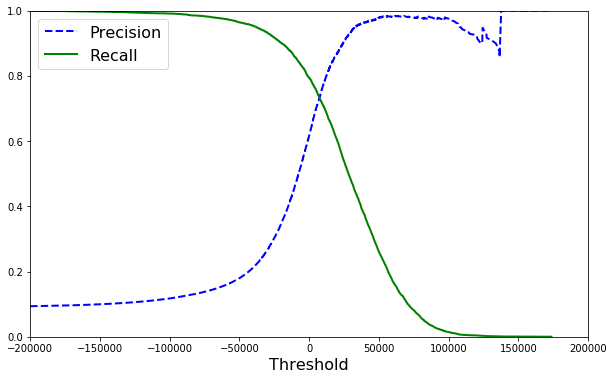

In [72]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-200000, 200000])
plt.show()

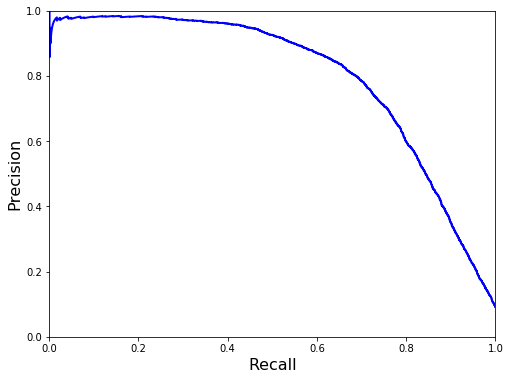

In [73]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROV (receiver operating characteristic) curve

* plot TPR vs FPR (true positive rate vs false positive rate)

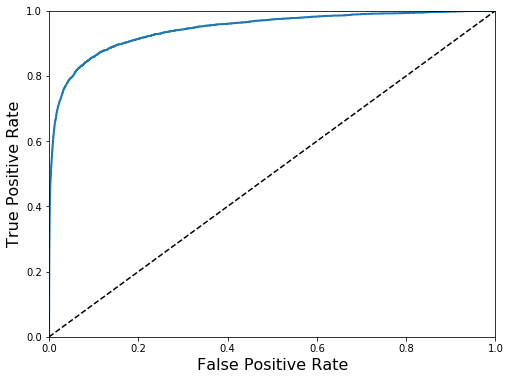

In [74]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [75]:
roc_auc_score(y_train_5, y_scores)

0.9446786853398694

### Random forest

In [94]:
forest = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method="predict_proba")

In [95]:
y_scores_forest = y_probas_forest[:, 1] # positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

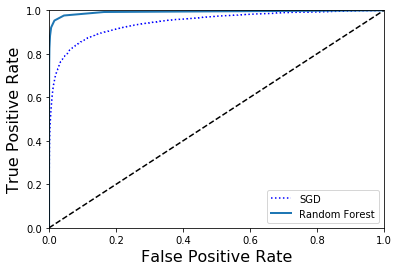

In [96]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9924686324366888

In [80]:
y_train_pred_forest = cross_val_predict(forest, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9867812293456708, 0.8262313226342003)

### Multiclass classification

* when feeded with multiple classes data, the SGDClassifier creates N-binary classfiers (using one-versus-all strategy) and predicts based on the highest score

In [81]:
sgd.fit(X_train, y_train) # we train against whole dataset, not only 5's
sgd.predict([some_digit])

array([5.])

* let's see the scores for this image from each classifier

In [82]:
sgd.decision_function([some_digit])

array([[ -94689.02901738, -111950.5050993 , -117981.85057614,
        -114350.98717564,  -61484.53570855,   59651.15800856,
        -149692.42084672,  -57526.28040873,   -4394.11925435,
         -78382.80336458]])

In [83]:
sgd.decision_function([some_digit])[:,5]

array([59651.15800856])

In [84]:
sgd.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

* we can force to use OneVsOne or OneVsRest explicitely

In [85]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [86]:
len(ovo_clf.estimators_) # N(N-1)/2

45

* random forest also supports multiclass data

In [87]:
forest.fit(X_train, y_train) # we are training across all digits
forest.predict([some_digit])

array([5.])

In [88]:
forest.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0.1, 0. ]])

* let's evaluate now sgd classifier with 10 classes

In [89]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")

array([0.87637473, 0.88624431, 0.88503275])

In [90]:
cross_val_score(never_5, X_train, y_train, cv=3, scoring="accuracy") # random classifier gets on average 10% as expected

array([0.0972 , 0.0991 , 0.09985])

* now we can improve 85% score by scaling data from 0-255 range to ?-? range

In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [97]:
X_train_scaled.min(), X_train_scaled.max() 

(-1.2742078920822253, 244.9469330286622)

In [98]:
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90391922, 0.9020951 , 0.90278542])

In [99]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5619,    0,   17,    7,    6,   42,   34,    6,  191,    1],
       [   1, 6428,   45,   19,    3,   46,    5,    9,  176,   10],
       [  30,   26, 5276,   92,   68,   22,   68,   38,  326,   12],
       [  29,   22,  126, 5253,    1,  208,   27,   46,  351,   68],
       [  11,   14,   46,   13, 5204,   15,   36,   22,  296,  185],
       [  31,   18,   28,  155,   50, 4522,   80,   18,  456,   63],
       [  28,   18,   50,    2,   38,   99, 5550,    5,  128,    0],
       [  22,   12,   56,   25,   46,   11,    6, 5739,  142,  206],
       [  24,   67,   38,  100,    1,  122,   36,    8, 5411,   44],
       [  27,   23,   28,   59,  116,   34,    1,  181,  306, 5174]])

### Multilabel classification

In [100]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
# don't enable, takes too long to process
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred, average='macro')